In [1]:
import sys
import os
import matplotlib.pyplot as plt

import numpy as np
import highdicom as hd

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import scripts.dicom as dicom



In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
path = os.path.abspath(os.path.join(os.getcwd(), "..", "data", "1685", "10_AP_Ax2.50mm"))

print(f"Loading DICOM files from {path}")
slices = dicom.load_dicom(path)

img_dcm = dicom.create_3d_array_from_dicom(slices)
# img_dcm = np.flip(img_dcm, axis=0)  # Change orientation (better visualization)

print(f"3D image shape: {img_dcm.shape}")

# Obtain the pixel spacing, we will use the index 0, as all slices have the same spacing
pixel_spacing = slices[0].get("PixelSpacing")
print(f"Pixel spacing: {pixel_spacing}")

slice_spacing = slices[0].get("SpacingBetweenSlices")
print(f"Slice spacing: {slice_spacing}")

Loading DICOM files from /Users/josep/Documents/master/11763-Medical-Image-Processing-Final-Project/data/1685/10_AP_Ax2.50mm
3D image shape: (86, 512, 512)
Pixel spacing: [0.767578, 0.767578]
Slice spacing: 2.5


In [4]:
tumor_path = os.path.abspath(os.path.join(os.getcwd(), "..", "data", "1685", "10_AP_Ax2.50mm_ManualROI_Tumor.dcm"))

seg = hd.seg.segread(tumor_path)

mask = seg.pixel_array

# 1. Obtain the Z positions of each slice of the original volume (CT)
ct_z_positions = [float(slice.ImagePositionPatient[2]) for slice in slices]

# 2. Obtain the Z positions of each slice of the tumor
tumor_z_positions = [
    float(frame.PlanePositionSequence[0].ImagePositionPatient[2])
    for frame in seg.PerFrameFunctionalGroupsSequence
]

# 3. Mapping the tumor slice indices to the original volume
tumor_slice_indices = [ct_z_positions.index(z) for z in tumor_z_positions]

# 4. Creathe the empty mask
full_mask = np.zeros_like(img_dcm, dtype=np.uint8)

# 5. Assign each slice of the tumor to its position
for i, idx in enumerate(tumor_slice_indices):
    full_mask[idx] = mask[i]

print(f"Full mask shape: {full_mask.shape}")

Full mask shape: (86, 512, 512)


In [ ]:
import numpy as np
from scipy.ndimage import label, center_of_mass, find_objects

# Detect tumors in the full mask
labeled_mask, num_features = label(full_mask)
print(f"Number of connected components (tumors): {num_features}")
print(f"Labelled mask shape: {labeled_mask.shape}")

# Obtain the different bounding boxes of the tumors
bounding_boxes = find_objects(labeled_mask)

# Obtain the centroids of the tumors
centroids = center_of_mass(full_mask, labeled_mask, range(1, num_features + 1))

# Show the results
for i, (bbox, centroid) in enumerate(zip(bounding_boxes, centroids), start=1):
    z_slice, y_slice, x_slice = bbox
    print(f"Tumor {i}:")
    print(f"  Bounding box: Z={z_slice}, Y={y_slice}, X={x_slice}")
    print(f"  Centroid: Z={centroid[0]:.2f}, Y={centroid[1]:.2f}, X={centroid[2]:.2f}")

bbox_coords = []
for bbox in bounding_boxes:
    z, y, x = bbox
    bbox_coords.append((
        (z.start, y.start, x.start),
        (z.stop, y.stop, x.stop)
    ))

# Print the bounding box coordinates
for i, (start, stop) in enumerate(bbox_coords, start=1):
    print(f"Tumor {i} bounding box coordinates:")
    print(f"  Start: {start}")
    print(f"  Stop: {stop}")

Number of connected components (tumors): 5
Labelled mask shape: (86, 512, 512)
Number of bounding boxes: 5
[(slice(26, 31, None), slice(155, 173, None), slice(262, 277, None)), (slice(26, 32, None), slice(254, 270, None), slice(84, 99, None)), (slice(45, 53, None), slice(136, 169, None), slice(271, 300, None)), (slice(55, 58, None), slice(255, 271, None), slice(87, 104, None)), (slice(58, 65, None), slice(180, 208, None), slice(117, 143, None))]
Tumor 1:
  Bounding box: Z=slice(26, 31, None), Y=slice(155, 173, None), X=slice(262, 277, None)
  Centroid: Z=28.21, Y=163.07, X=269.10
Tumor 2:
  Bounding box: Z=slice(26, 32, None), Y=slice(254, 270, None), X=slice(84, 99, None)
  Centroid: Z=28.71, Y=261.71, X=90.43
Tumor 3:
  Bounding box: Z=slice(45, 53, None), Y=slice(136, 169, None), X=slice(271, 300, None)
  Centroid: Z=48.25, Y=152.42, X=283.37
Tumor 4:
  Bounding box: Z=slice(55, 58, None), Y=slice(255, 271, None), X=slice(87, 104, None)
  Centroid: Z=56.09, Y=262.73, X=94.45
Tumor 5

In [17]:
# Predict the tumor volume

from skimage.filters import threshold_otsu

segmented_masks = []

for i, bbox in enumerate(bounding_boxes):
    z, y, x = bbox

    # Crop the subvolume from the CT image
    img_crop = img_dcm[z, y, x]

    # Flatten the subvolume to compute a global threshold
    flat = img_crop.flatten()
    flat = flat[flat > 0]  # Optional: remove background values

    if len(flat) == 0:
        segmented_masks.append(None)
        continue

    # Compute Otsu's threshold
    threshold = threshold_otsu(flat)

    # Create a binary mask using the threshold
    mask_seg = img_crop > threshold

    # Store the segmented mask
    segmented_masks.append(mask_seg)

# Initialize a blank mask with the same shape as the CT image
predicted_mask = np.zeros_like(img_dcm, dtype=bool)

# Insert each local segmentation into the full predicted mask
for bbox, local_mask in zip(bounding_boxes, segmented_masks):
    if local_mask is None:
        continue
    z, y, x = bbox
    predicted_mask[z, y, x] = local_mask

print(f"Predicted mask shape: {predicted_mask.shape}")

Predicted mask shape: (86, 512, 512)


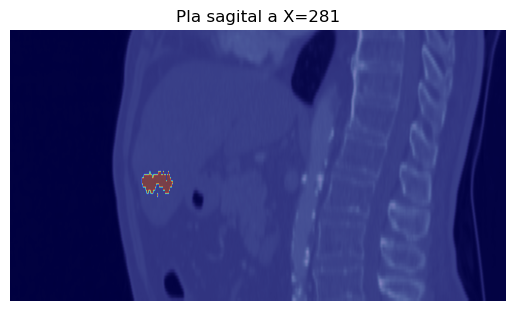

In [18]:
sagital_sum = predicted_mask.sum(axis=(0,1))  # Shape: (X,)
max_index = np.argmax(sagital_sum)

# plane = img_dcm[:, :, max_index]
plane = dicom.median_sagittal_plane(img_dcm)
mask_plane = predicted_mask[:, :, max_index]

plt.imshow(plane, cmap="bone", aspect=slice_spacing / pixel_spacing[0])
plt.imshow(mask_plane, cmap="jet", alpha=0.5, aspect=slice_spacing / pixel_spacing[0])
plt.title(f"Pla sagital a X={max_index}")
plt.axis("off")
plt.show()

In [21]:
import scipy

def rotate_on_axial_plane(img_dcm: np.ndarray, angle_in_degrees: float) -> np.ndarray:
    """ Rotate the image on the axial plane. """
    return scipy.ndimage.rotate(img_dcm, angle_in_degrees, axes=(1, 2), reshape=False)

img_min = np.amin(img_dcm)
img_max = np.amax(img_dcm)
cm = 'bone'

output_dir = '../outputs/projection_prediction/'
os.makedirs(output_dir, exist_ok=True)

n = 16

for idx, alpha in enumerate(np.linspace(0, 360*(n-1)/n, num=n)):
    # Rotatem the image and the mask
    rotated_img = rotate_on_axial_plane(img_dcm, alpha)
    rotated_mask = rotate_on_axial_plane(predicted_mask, alpha)

    # Create the MIP projection
    projection = dicom.MIP_sagittal_plane(rotated_img)
    projection_mask = dicom.MIP_sagittal_plane(rotated_mask)
    # No mather if we do MIP_sagittal_plane or MIP_coronal_plane, the result is the same
    
    # MIP the mask
    sagittal_mask = rotated_mask.max(axis=2) 

    fig, ax = plt.subplots()
    ax.imshow(projection, cmap=cm, vmin=img_min, vmax=img_max, aspect=slice_spacing / pixel_spacing[0])
    ax.imshow(projection_mask, cmap="jet", alpha=0.5, aspect=slice_spacing / pixel_spacing[0])
    ax.axis("off")
    fig.savefig(os.path.join(output_dir, f'Projection_{idx}.png'), bbox_inches='tight', pad_inches=0)
    plt.close(fig)


In [22]:
from PIL import Image

# Route
image_folder = '../outputs/projection_prediction/'
output_gif = '../outputs/projection_prediction/Animation.gif'

# Sort the image files by their index
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.png')],
                     key=lambda x: int(x.split('_')[-1].split('.')[0]))

# Load images
images = [Image.open(os.path.join(image_folder, f)) for f in image_files]

# Save as GIF
images[0].save(
    output_gif,
    save_all=True,
    append_images=images[1:],
    duration=250,
    loop=0
)